Check also https://www.authorea.com/users/173169/articles/208172-october-25-2017-summary-of-individual-fish-stochastic-swimming-model-and-fitting-results

Check coordinate system.

In [1]:
%matplotlib inline
import numpy as np
import dill as pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import sys
sys.path.append('../')
from numba import jit

from scipy.optimize import minimize, least_squares, curve_fit
from scipy.integrate import quad
from scipy.stats import spearmanr
from sklearn.mixture import GaussianMixture
from calovi import WallModel, SocialModel, KickModel

import sklearn.model_selection as cv
np.set_printoptions(suppress=True)

/home/lukas/bin/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


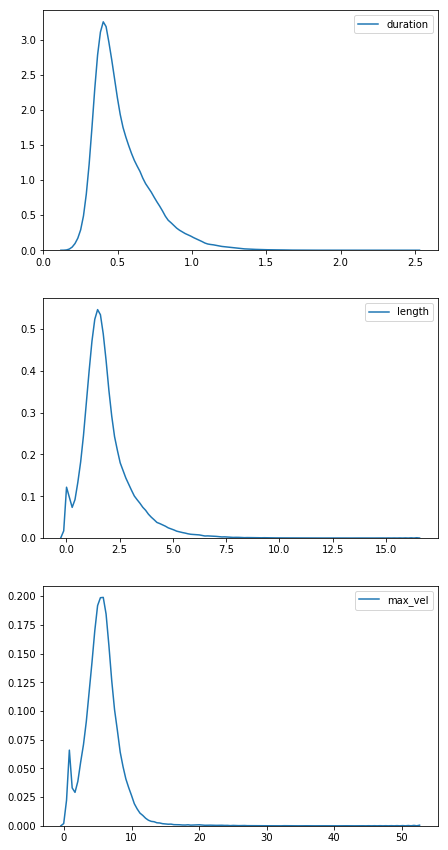

In [2]:
df = pd.read_csv("../../data/processed/kicks_guy.csv")
train, test = cv.train_test_split(df, train_size=0.8)
# TODO: Move to other notebook
fig, ax = plt.subplots(3, figsize=(5*2**(0.5), 3*5))
sns.kdeplot(df['duration'],ax=ax[0])
sns.kdeplot(df['length'], ax=ax[1])
sns.kdeplot(df['max_vel'], ax=ax[2])

fig.savefig('../../figures/kick_plots.pdf')
def fit_mixture(df, column, n_components=2):
    var = df[column].values.reshape(-1, 1)
    mix = GaussianMixture(n_components=n_components)
    mix.fit(var)
    return mix

# Create models for duration, length, max_velocity that we can sample from
duration_gmm = fit_mixture(df, 'duration')
length_gmm = fit_mixture(df, 'length')
max_vel_gmm = fit_mixture(df, 'max_vel')

In [4]:
len(train), len(test), len(df)

(103516, 25879, 129395)

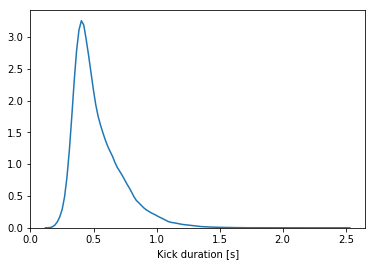

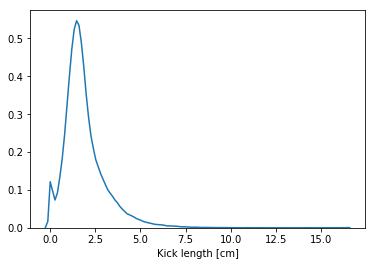

In [3]:
fig, ax = plt.subplots()
sns.kdeplot(df['duration'],ax=ax)
ax.legend_.remove()
ax.set_xlabel("Kick duration [s]")
fig.savefig('../../figures/kick_duration.pdf', transparent=True, bbox_inches='tight')

fig, ax = plt.subplots()
sns.kdeplot(df['length'],ax=ax)
ax.legend_.remove()
ax.set_xlabel("Kick length [cm]")
fig.savefig('../../figures/kick_length.pdf', transparent=True, bbox_inches='tight')

0.966331559645
0.7631253116530446


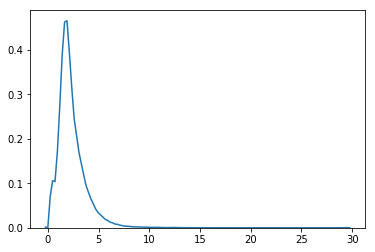

In [4]:
# Quick hack to find velocity decay parameter!
x0 = np.array([0.10])
max_vel = df['max_vel'].values
end_vel = df['end_vel'].values
length = df['length']
duration = df['duration'].values
vel_ratio = end_vel/max_vel
#decay = lambda time, decay_time: np.exp(-time/decay_time)
decay = lambda time, decay_time: np.exp(-time * decay_time)
res = curve_fit(decay, xdata=duration, ydata=vel_ratio, p0=x0)
velocity_decay_time = res[0][0]
print(velocity_decay_time)
# Check approximation of length by Calovis exponential decay model
length_hat = max_vel * velocity_decay_time * \
            (1 - np.exp(-duration/res[0]))
print(np.mean((length -  length_hat)**2))
sns.kdeplot(length_hat)

In [5]:
kick_model = KickModel(max_vel_gmm, duration_gmm, velocity_decay_time)
with open('../calovi_kick.model', 'wb') as f:
    pickle.dump(kick_model, f)
kick_model.get_peak_speed(), kick_model.get_kick_duration(), kick_model.get_velocity_decay_time()

(3.4218308718823396, 0.48709853750000609, 0.9663315596451989)

In [6]:
# Find average heading change without wall influence.
threshold = 10.0 # cm
condition = (df['wall_distance0_f0'] > threshold) & (df['wall_distance1_f0'] > threshold) & \
            (df['wall_distance2_f0'] > threshold) & (df['wall_distance3_f0'] > threshold)
    
print(f"We're considering {len(df[condition])} rows.")
free_heading = df[condition]['heading_change']
(np.array([free_heading.std(), free_heading.mean()]))

We're considering 13410 rows.


array([ 1.07530161,  0.02804682])

In [7]:
#df = df.drop(df[df['neighbor_distance'] < 10].index) # No kicks where fish are close
#df = df.drop(df[df['geometric_leader'] != 'f0'].index) 
#df = df.drop(df[df['fish_id'] != 'f0'].index)

df.index = np.arange(0, len(df))
#df.index = np.arange(0, len(df))
df.describe()

,heading_change,duration,gliding_duration,length,max_vel,end_vel,neighbor_distance,neighbor_angle,viewing_angle_ltf,viewing_angle_ftl,...,wall_angle2_f0,wall_angle3_f0,wall_distance0_f1,wall_distance1_f1,wall_distance2_f1,wall_distance3_f1,wall_angle0_f1,wall_angle1_f1,wall_angle2_f1,wall_angle3_f1
count,129395.000000,129395.000000,129395.000000,129395.000000,129395.000000,129395.000000,129395.000000,129395.000000,129395.000000,129395.000000,...,129395.000000,129395.000000,129395.000000,129395.000000,129395.000000,129395.000000,1.293950e+05,129395.000000,129395.000000,129395.000000
mean,-0.001289,0.531179,0.266371,1.865546,5.690878,3.487612,3.321156,0.017307,-0.041587,0.022256,...,-1.569417,0.039133,17.921546,17.266915,18.085237,16.294389,1.573054e+00,0.002257,-1.568442,0.043410
std,1.077267,0.193875,0.125659,1.187150,2.710450,2.546288,4.905609,1.818197,2.141485,1.443410,...,0.915802,2.421125,10.265567,10.045143,10.443751,10.424172,9.139843e-01,0.913984,0.914151,2.421491
min,-3.133629,0.170000,0.010000,0.000063,0.174125,-33.799212,0.158530,-3.141543,-3.141554,-3.126449,...,-3.141571,-3.141593,0.126174,0.009460,0.199106,0.066492,-4.420510e-08,-1.570796,-3.141576,-3.141593
25%,-0.314021,0.390000,0.190000,1.163742,4.171667,1.335425,1.637019,-1.536433,-2.148911,-1.007738,...,-2.315282,-2.329016,8.671085,7.707230,8.632353,6.235042,8.288053e-01,-0.741991,-2.312744,-2.326424
50%,0.000606,0.480000,0.230000,1.636847,5.547787,3.274859,2.219883,-0.004648,-0.277222,0.033174,...,-1.583144,1.586188,17.788432,17.438731,18.205910,16.138573,1.557702e+00,-0.013094,-1.583871,1.588633
75%,0.316711,0.620000,0.300000,2.308361,6.941052,5.116077,2.948296,1.605697,2.094862,1.052350,...,-0.784724,2.423491,27.228332,26.951133,27.179417,25.667890,2.357216e+00,0.786420,-0.784300,2.428057
max,3.133023,2.480000,1.830000,16.319537,51.976359,51.976359,37.683365,3.141561,3.141579,3.138005,...,3.141593,3.141578,36.927160,35.191064,39.452134,40.309543,3.141578e+00,1.570782,3.141593,3.141572


In [8]:
# Try grad.desc as a sanity check
def calc_wall_error(model, xdata, ydata, params=None):
    lambda_reg = 0.0
    return np.linalg.norm(model(xdata) - ydata)/(len(ydata))

#fCur = lambda dist: f(dist, 1.9)
#OCur = lambda angle: O(angle, 0.8, 0.0)
#calc_wall_error(heading_change, wall_distance0, wall_angle0, fCur, OCur)

def compute_r2(x, y, model=None, yhat=None):
    if yhat is None:
        yhat = model(x)
    residuals = y - yhat
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    return 1 - (ss_res/ss_tot)

In [9]:
def get_data_wall(data):  
    heading_change = data['heading_change'].values
    wall_distance = np.vstack([data[f'wall_distance{i}_f0'].values for i in range(4)])
    wall_angle = np.vstack([-data[f'wall_angle{i}_f0'].values for i in range(4)])
    xdata_wall = np.vstack((wall_distance, wall_angle))
    ydata = heading_change

    return xdata_wall, ydata

def fit_wall(data):
    # Setup data.   
    xdata_wall, ydata = get_data_wall(train)   

    # Initialise model with standard parameters.
    angular_model = 'sin-cos'
    wall_model = WallModel(angular_model)
    angular = WallModel.angular_map
    init_x = WallModel.params_map

    # Setup helper methods and bounds for optimizer.
    x0 = init_x[angular_model]

    l_bounds = np.array([-np.inf] * len(x0))
    u_bounds = np.array([ np.inf] * len(x0))

    l_bounds[1] = 0.0 # no negative decay
    bounds = (l_bounds, u_bounds)

    # Fit the model
    res = curve_fit(wall_model.evaluate_raw, xdata=xdata_wall, ydata=ydata, p0=x0, bounds=bounds,max_nfev=1000000)
    x_opt_wall = res[0]
    
    wall_model.set_params(x_opt_wall)
    return wall_model, x0, x_opt_wall

wall_model, x0, x_opt_wall = fit_wall(train)

# Evaluate the model for both datasets
def evaluate_model(data, wall_model, x0, x_opt_wall):
    xdata_wall, ydata = get_data_wall(data)
    fitted_model = lambda xdata: wall_model.evaluate_raw(xdata, *x_opt_wall)
    random_model = lambda xdata: wall_model.evaluate_raw(xdata, *x0)
    mean_model = lambda xdata: np.ones_like(xdata) * np.mean(ydata)

    print(f"Curve fit reached error of {calc_wall_error(fitted_model, xdata_wall, ydata, x_opt_wall)} with params={str(x_opt_wall)}")
    print(f"1-Std-error of params is {np.sqrt(np.diag(res[1]))}")
    print(f"Random params reached error of {calc_wall_error(random_model, xdata_wall, ydata, x0)} with params={x0}")

    # Calculate error for mean heading change as model
    mean_heading_error = calc_wall_error(mean_model, xdata_wall, ydata, np.array([0.0]))
    print(f"Predicting the average heading {np.mean(ydata)} for each heading leads to an error of {mean_heading_error}")

    print(f"Model has r^2 of {compute_r2(xdata_wall, ydata, fitted_model)}")
    yHat = fitted_model(xdata_wall)
    print(f"Correlation={np.corrcoef(ydata, yHat)[0][1]}")
    print(f"{spearmanr(ydata, -fitted_model(xdata_wall))}")

    
print("Evaluating training loss:")
evaluate_model(train, wall_model, x0, x_opt_wall)

print('\n', '-'*100)
print("Evaluating testing loss:")
evaluate_model(test, wall_model, x0, x_opt_wall)

# Save fitted model to file.
with open('../calovi_wall.model', 'wb') as file:
    pickle.dump(wall_model, file)

Evaluating training loss:
Curve fit reached error of 0.003198706539853399 with params=[  1.10484026  22.4564495    0.95812338   0.34380032  -2.72488652
   0.97024129]
1-Std-error of params is [ 0.00279821]
Random params reached error of 0.003437794198652614 with params=[ 1.   6.   0.7  0.   0.   0. ]
Predicting the average heading -0.0002879673744323498 for each heading leads to an error of 0.009476463721598764
Model has r^2 of 0.08852203334995257
Correlation=0.2976093759797831
SpearmanrResult(correlation=-0.23076378355154817, pvalue=0.0)

 ----------------------------------------------------------------------------------------------------
Evaluating testing loss:
Curve fit reached error of 0.006380254636131787 with params=[  1.10484026  22.4564495    0.95812338   0.34380032  -2.72488652
   0.97024129]
1-Std-error of params is [ 0.00279821]
Random params reached error of 0.006871633780452823 with params=[ 1.   6.   0.7  0.   0.   0. ]
Predicting the average heading -0.00529071451422135

1.10484026441 0.4765514365334756
Multiplier is 0.5265132151447068


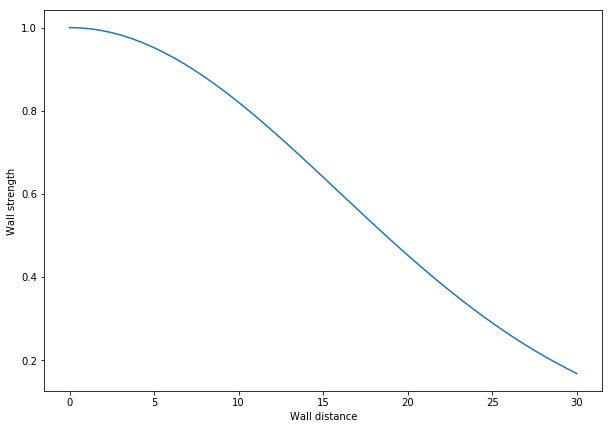

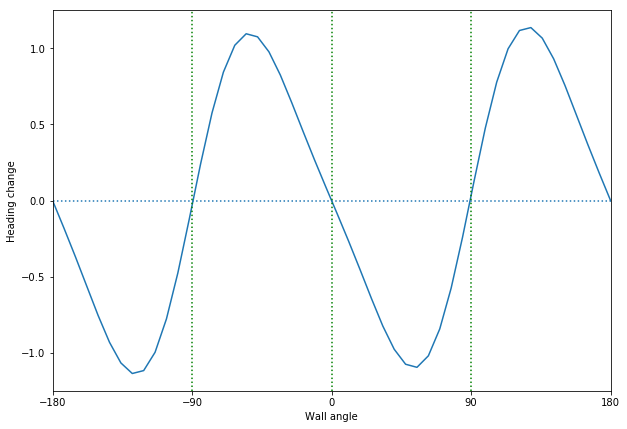

In [10]:
def get_norm_const(OCur, angles):
    return 1/(2*np.pi) * quad(lambda a: OCur(a)**2, -np.pi, np.pi)[0]

def plotFit(model):
    fCur = lambda dist: wall_model.wall_force(dist)
    OCur = lambda angle: wall_model.wall_repulsion(angle)
    norm_const = get_norm_const(OCur, np.linspace(-np.pi, np.pi))
    #norm_const = 1.0/wall_model.scale
    print(wall_model.scale, norm_const)
    print(f"Multiplier is {norm_const * wall_model.scale}")
    
    fig, ax = plt.subplots(figsize=(10,7) )    
    ax.plot(np.linspace(0, 30), fCur(np.linspace(0,30)))
    ax.set_xlabel("Wall distance")
    ax.set_ylabel("Wall strength")
    fig.savefig('../../figures/wall_force.pdf', transparent=True, bbox_inches='tight')    
       
    fig, ax = plt.subplots(figsize=(10,7) )
    ax.plot(np.rad2deg(np.linspace(-np.pi, np.pi)), OCur(np.linspace(-np.pi, np.pi))*wall_model.scale)
    plt.axhline(0, linestyle='dotted')
    ax.axvline(90, linestyle='dotted', c='g')
    ax.axvline(0.0, linestyle='dotted', c='g')
    ax.axvline(-90, linestyle='dotted', c='g')
    ax.set_xticks([-180, -90, 0, 90, 180])
    ax.set_xlim(-180, 180)
    ax.set_xlabel("Wall angle")
    ax.set_ylabel("Heading change")
    fig.savefig('../../figures/wall_odd.pdf', transparent=True, bbox_inches='tight')
    
plotFit(wall_model)

In [18]:
def toMin(model, xdata_social, ydata):
    yHat = model(xdata_social)
    return np.linalg.norm(yHat - ydata)/len(ydata)

def get_data_social(data):
    dff = data
    for i in range(4):
        dff = dff.drop(dff[dff[f'wall_distance{i}_f0'] < 5].index)
        
    # Data
    heading_change = dff['heading_change'].values
    neighbor_distance = dff['neighbor_distance']
    viewing_angle = np.zeros(dff['viewing_angle_ftl'].shape)

    # Angles between fish are saved w.r.t. geometric leader
    fish_is_leader = dff['fish_id'] == dff['geometric_leader']
    viewing_angle[fish_is_leader] = dff['viewing_angle_ltf'][fish_is_leader]
    viewing_angle[~fish_is_leader] = dff['viewing_angle_ftl'][~fish_is_leader]
    relative_angle = np.zeros(dff['rel_orientation'].shape)
    relative_angle[fish_is_leader] = dff['rel_orientation'][fish_is_leader]
    relative_angle[~fish_is_leader] = -dff['rel_orientation'][~fish_is_leader]

    # Get correct xdata for wall estimation!
    xdata_wall, _ = get_data_wall(dff)

    xdata_social = np.vstack((neighbor_distance, viewing_angle, relative_angle))
    ydata = heading_change
    
    return xdata_wall, xdata_social, ydata    

def fit_social(data, wall_model, num_fourier):
    xdata_wall, xdata_social, ydata = get_data_social(data)

    social_model = SocialModel(num_fourier=num_fourier)
    x0 = social_model.params
    eval_social_model = lambda xdata, *params: social_model.evaluate_raw(xdata, *params)
    eval_wall_model = lambda xdata, *params: wall_model.evaluate_raw(xdata, *params)

    res = curve_fit(eval_social_model, xdata=xdata_social, ydata=ydata - eval_wall_model(xdata_wall, *x_opt_wall), 
                    p0=x0, maxfev=50000)
    x_opt_social = res[0]
    
    social_model.set_params(x_opt_social)
    return social_model, x_opt_social, x0

social_model, x_opt_social, x0 = fit_social(train, wall_model, 5)

def evaluate_social(data, x_opt_social, x0, social_model, wall_model):
    xdata_wall, xdata_social, ydata = get_data_social(data)
    fitted_model = lambda xdata: social_model.evaluate_raw(xdata, *x_opt_social)
    random_model = lambda xdata: social_model.evaluate_raw(xdata, *x0)

    print(f"Curve fit reached error of {toMin(fitted_model, xdata_social, ydata)} with params={str(x_opt_social)}")
    print(f"1-Std-error of params is {np.sqrt(np.diag(res[1]))}")
    print(f"Random params reached error of {toMin(random_model, xdata_social, ydata)} with params={x0}")

    # Calculate error for mean heading change as model
    mean_heading = np.mean(ydata)
    mean_heading_error = np.sum( (ydata - mean_heading)**2 )
    print(f"Predicting the average heading {mean_heading} for each heading leads to an error of {mean_heading_error}")

    print(f"Model has r^2 of {compute_r2(xdata_social, ydata, fitted_model)}")
    yHat = fitted_model(xdata_social)
    print(f"Correlation={np.corrcoef(ydata, yHat)[0,1]}")

    yHat_full = fitted_model(xdata_social) + wall_model.evaluate_raw(xdata_wall, *wall_model.params)
    print(f"Full model correlation={np.corrcoef(ydata, yHat_full)[0,1]}")
    print(f"Full Model has r^2 of {compute_r2(xdata_social, ydata, yhat=yHat_full)}")

print("Evaluating training loss:")
evaluate_social(train, x_opt_social, x0, social_model, wall_model)

print('\n', '-'*100)
print("Evaluating testing loss:")
evaluate_social(test, x_opt_social, x0, social_model, wall_model)

wall_model.set_params(x_opt_wall)
# Save fitted model to file.
with open('../calovi_social.model', 'wb') as file:
    pickle.dump(social_model, file)

Evaluating training loss:
Curve fit reached error of 0.004612294934174177 with params=[   2.83959572  136.81377146    0.01298827  343.78452486   25.36596703
    0.02463065   -0.00394982   -0.00401095   -0.00257595   -0.00086376
   -0.00188701  263.16646473   80.6577595     2.95957683 -226.319646
   63.96469678    0.08041294   -0.03261697    0.02143542   -0.02188676
    0.01845694   -0.02418444    0.01852284   -0.01795172    0.01088969
    0.00317017]
1-Std-error of params is [ 0.00279821]
Random params reached error of 0.005099076994187687 with params=[ 0.3  2.   1.   1.   1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
Predicting the average heading 0.02992436570982571 for each heading leads to an error of 52160.4021342112
Model has r^2 of 0.18118659388118696
Correlation=0.43707007622456834
Full model correlation=0.4678480627451566
Full Model has r^2 of 0.21470042551304003

 -------------------------------------------------

# 2
    Evaluating training loss:
    Curve fit reached error of 0.004692121891352785 with params=[   2.00979925    2.63263606    2.20436571  634.18443822   24.37693488
        0.016368     -0.00227961   -0.01238482   -2.80861093    4.28827237
        0.07183689   -0.02347894   -0.02338308    0.01760403]
    1-Std-error of params is [ 0.00279821]
    Random params reached error of 0.005099076994187687 with params=[ 0.3  2.   1.   1.   1.   1.   0.   0.   0.   0.   0.   0.   0.   0. ]
    Predicting the average heading 0.02992436570982571 for each heading leads to an error of 52160.4021342112
    Model has r^2 of 0.15259821450352573
    Correlation=0.4015098581625189
    Full model correlation=0.445833431550288
    Full Model has r^2 of 0.19534553452794678

     ----------------------------------------------------------------------------------------------------
    Evaluating testing loss:
    Curve fit reached error of 0.009420352571387701 with params=[   2.00979925    2.63263606    2.20436571  634.18443822   24.37693488
        0.016368     -0.00227961   -0.01238482   -2.80861093    4.28827237
        0.07183689   -0.02347894   -0.02338308    0.01760403]
    1-Std-error of params is [ 0.00279821]
    Random params reached error of 0.01027702732006302 with params=[ 0.3  2.   1.   1.   1.   1.   0.   0.   0.   0.   0.   0.   0.   0. ]
    Predicting the average heading 0.016327764775137876 for each heading leads to an error of 13293.000512051934
    Model has r^2 of 0.159578785087221
    Correlation=0.41227587453546055
    Full model correlation=0.4535136896449818
    Full Model has r^2 of 0.20368596589464116


# 3
    Evaluating training loss:
    Curve fit reached error of 0.004648041284177295 with params=[   2.30198052  103.92124441    0.04764771  365.44930866   24.18811501
        0.02376134   -0.001014     -0.00109067   -0.00037015  276.03116036
       78.45655198 -149.54319686    0.07957455   -0.03656765    0.02020701
       -0.03241959    0.01680507   -0.0259889 ]
    1-Std-error of params is [ 0.00279821]
    Random params reached error of 0.005099076994187687 with params=[ 0.3  2.   1.   1.   1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
      0.   0.   0. ]
    Predicting the average heading 0.02992436570982571 for each heading leads to an error of 52160.4021342112
    Model has r^2 of 0.16844542530363316
    Correlation=0.4224478652796119
    Full model correlation=0.45651794532654844
    Full Model has r^2 of 0.20433326438431676

     ----------------------------------------------------------------------------------------------------
    Evaluating testing loss:
    Curve fit reached error of 0.009336980846214126 with params=[   2.30198052  103.92124441    0.04764771  365.44930866   24.18811501
        0.02376134   -0.001014     -0.00109067   -0.00037015  276.03116036
       78.45655198 -149.54319686    0.07957455   -0.03656765    0.02020701
       -0.03241959    0.01680507   -0.0259889 ]
    1-Std-error of params is [ 0.00279821]
    Random params reached error of 0.01027702732006302 with params=[ 0.3  2.   1.   1.   1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
      0.   0.   0. ]
    Predicting the average heading 0.016327764775137876 for each heading leads to an error of 13293.000512051934
    Model has r^2 of 0.17438870052626998
    Correlation=0.4311340253097386
    Full model correlation=0.4632794071217243
    Full Model has r^2 of 0.21211952893374708
    
# 4
    Evaluating training loss:
    Curve fit reached error of 0.004625170479730473 with params=[   2.65934188   42.79431855    0.19049364  250.65184196   27.36937319
        0.02985757   -0.0193785    -0.01414377   -0.01042974   -0.00387047
        3.93959578    1.90487307    0.11517506   -3.24961293    0.09068682
       -0.03729025    0.03025138   -0.0157115    -0.0304333     0.00511556
       -0.02534867    0.0032389 ]
    1-Std-error of params is [ 0.00279821]
    Random params reached error of 0.005099076994187687 with params=[ 0.3  2.   1.   1.   1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
      0.   0.   0.   0.   0.   0.   0. ]
    Predicting the average heading 0.02992436570982571 for each heading leads to an error of 52160.4021342112
    Model has r^2 of 0.17660866260639496
    Correlation=0.43306205907415307
    Full model correlation=0.4611828551620626
    Full Model has r^2 of 0.20822036515748843

     ----------------------------------------------------------------------------------------------------
    Evaluating testing loss:
    Curve fit reached error of 0.009308931349578987 with params=[   2.65934188   42.79431855    0.19049364  250.65184196   27.36937319
        0.02985757   -0.0193785    -0.01414377   -0.01042974   -0.00387047
        3.93959578    1.90487307    0.11517506   -3.24961293    0.09068682
       -0.03729025    0.03025138   -0.0157115    -0.0304333     0.00511556
       -0.02534867    0.0032389 ]
    1-Std-error of params is [ 0.00279821]
    Random params reached error of 0.01027702732006302 with params=[ 0.3  2.   1.   1.   1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
      0.   0.   0.   0.   0.   0.   0. ]
    Predicting the average heading 0.016327764775137876 for each heading leads to an error of 13293.000512051934
    Model has r^2 of 0.17934173555195188
    Correlation=0.43698538054550085
    Full model correlation=0.4651226165611038
    Full Model has r^2 of 0.21327689037879027
    
# 5

    Evaluating training loss:
    Curve fit reached error of 0.0046260260719089286 with params=[   1.98444244    2.97284547    0.00699154  829.76325935   24.83922691
        0.00062825   -4.81383292    1.61494235   -0.53361633    1.59566241
       -2.40202818    4.87401862   -3.46647437    1.79657183   -0.08206338
        1.33780695   -0.53774765    0.31057155   -0.32376489    0.2957736
       -0.01171963    0.02483068   -0.00912818    0.01752233   -0.00565406
        1.        ]

    Model has r^2 of 0.17775224714274918
    Correlation=0.43259793637971944
    Full model correlation=0.46535885129790194
    Full Model has r^2 of 0.21259900043037006

     ----------------------------------------------------------------------------------------------------
    Evaluating testing loss:
    Curve fit reached error of 0.00922158459258334
    Model has r^2 of 0.18915040696472796
    Correlation=0.44790610572460454
    Full model correlation=0.47679187318715477
    Full Model has r^2 of 0.22462266826231492


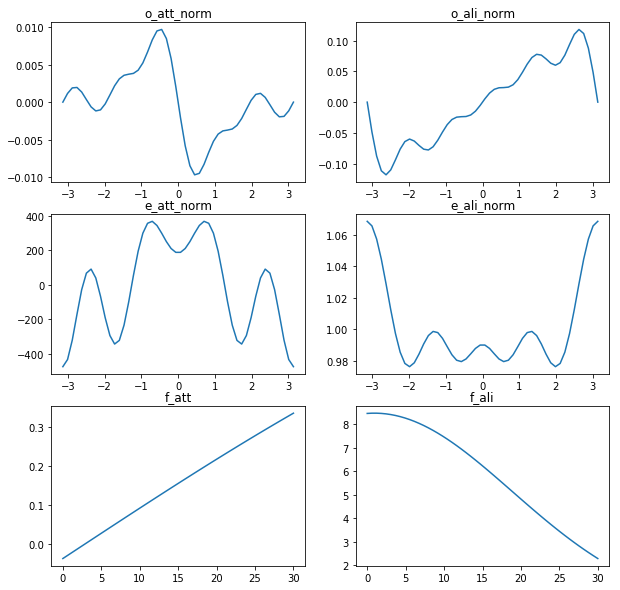

In [19]:
def get_norm_const(function, parameters):
    '''Normalizing factor s.t. square integral over -pi/pi is 1'''
    return 1/(2*np.pi) * quad(lambda a: function(a, *parameters)**2, -np.pi, np.pi)[0]

def eval_norm_func(function, parameters, angles):
    '''Evaluate a normalized angular function.
    Useful for plotting'''
    norm_const = get_norm_const(function, parameters)
    norm_const = 1.0
    return function(angles, *parameters) / norm_const

def get_params_slice(num_fun):
    '''Helper function for social model.
    TODO: Refactor this stuff out.'''
    params = x_opt_social
    offset = 5 + num_fun * num_params
    return params[offset:offset+num_params]

fig, ax = plt.subplots(3,2, figsize=(10,10))
x = np.linspace(-np.pi, np.pi)
#norm_factor = get_norm_const(o_att, get_params_slice(0)) * get_norm_const(e_att, get_params_slice(1))
ax[0][0].plot(x, social_model.o_att(x), label='o_att_norm')
ax[0][0].set_title("o_att_norm")
ax[1][0].plot(x, social_model.e_att(x), label='e_att_norm')
ax[1][0].set_title("e_att_norm")

ax[0][1].plot(x, social_model.o_ali(x), label='o_ali_norm')
ax[0][1].set_title("o_ali_norm")
ax[1][1].plot(x, social_model.e_ali(x), label='e_ali_norm')
ax[1][1].set_title("e_ali_norm")

x = np.linspace(0, 30)
ax[2][0].plot(x, social_model.f_att(x), label='f_att')
ax[2][0].set_title("f_att")
ax[2][1].plot(x, social_model.f_ali(x), label='f_ali')
ax[2][1].set_title("f_ali")

fig.savefig("../../figures/social_5_fourier.pdf", bbox_inches='tight')